In [19]:
#Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import os
import zipfile
import os
import re


In [20]:
import os
import pandas as pd


df = pd.read_csv("/Users/iphonex/Downloads/Court-Cases-Text-Analytics/Ontario-Court-Cases/data/canlii_final_report_20.csv")
clean_folder = "/Users/iphonex/Downloads/Court-Cases-Text-Analytics/Ontario-Court-Cases/data/data_clean"

# Build a mapping from Source URL in each txt -> text
url_to_text = {}

for fname in os.listdir(clean_folder):
    if fname.endswith(".txt"):
        file_path = os.path.join(clean_folder, fname)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        
        for line in text.splitlines():
            if line.lower().startswith("source url:"):
                url = line.split(":", 1)[1].strip()  
                url_to_text[url] = text
                break

# Align texts with CSV rows using URL

texts = []
missing_urls = []

for url in df['URL']:
    if url in url_to_text:
        texts.append(url_to_text[url])
    else:
        texts.append("")  # missing file
        missing_urls.append(url)


if missing_urls:
    print(f"WARNING: {len(missing_urls)} URLs in CSV do not have a corresponding txt file.")
    for url in missing_urls:
        print("Missing:", url)

print(f"Loaded {len(df)} cases and {len(texts)} texts")



Missing: https://www.canlii.org/en/on/oncj/doc/2025/2025oncj3/2025oncj3.html
Loaded 510 cases and 510 texts


### Sentence-BERT embeddings - Topic Modeling

In [21]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt

In [22]:
#Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, fast for 500+ cases
embeddings = model.encode(texts, show_progress_bar=True)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1810.77it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]


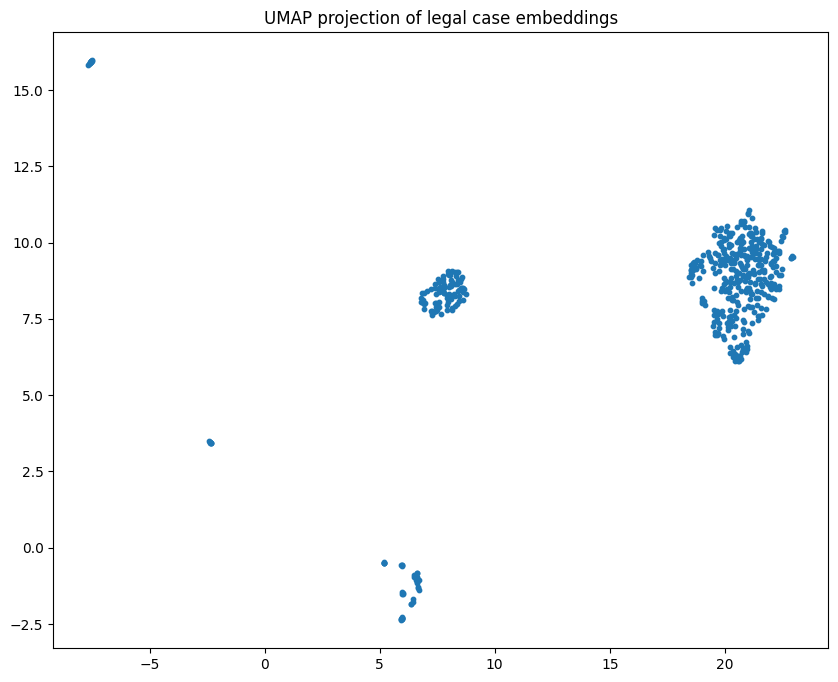

In [23]:
#Dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], s=10)
plt.title("UMAP projection of legal case embeddings")
plt.show()



The BERT sentence embedding approach seperated the cases into 3-4 groups. There is one larger cluster on the right, a medium one, a smaller one and one that seems to relate to outliers. However, since our sample is small to represent all possible criminal offense, we will chose to go with 4 clusters to represent the different cases complexities.

In [24]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(embeddings)

df['Cluster'] = cluster_labels

print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
print(df[['Case_Title', 'Cluster']].head(10))

Number of clusters found: 6
       Case_Title  Cluster
0      R. v. M.T.        4
1      R. v. J.G.        1
2  R. v. Laguerre        4
3     R. v. Khosa        1
4  R. v. Lachance        1
5     R. v. Eagen        1
6   R. v. Burnett        5
7    R. v. Nguyen       -1
8      R. v. P.G.        4
9    R. v. Cheema        1


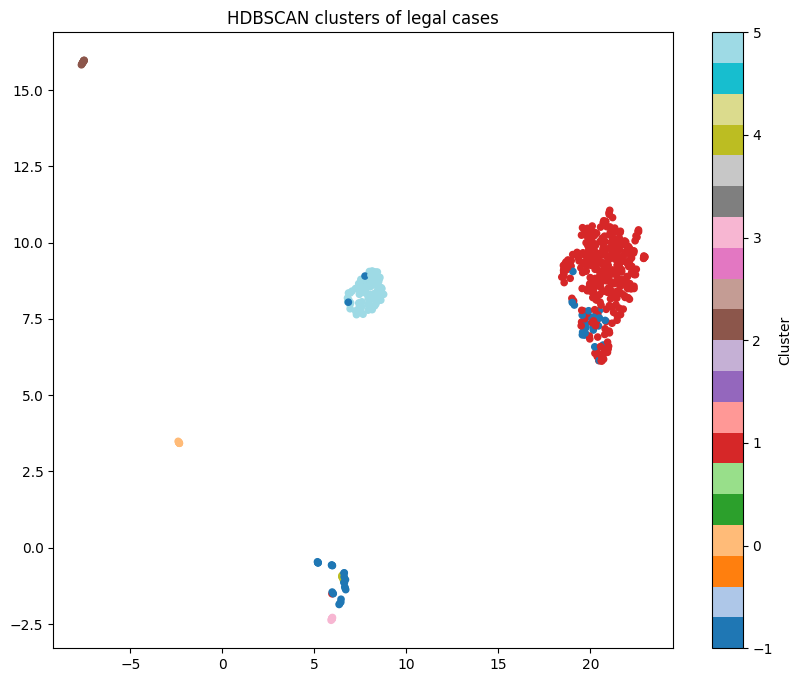

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=cluster_labels, cmap='tab20', s=20)
plt.colorbar(label='Cluster')
plt.title("HDBSCAN clusters of legal cases")
plt.show()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#Extact the top key words per cluster
def get_top_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Sum TF-IDF scores per term across all documents
    tfidf_sums = X.sum(axis=0).A1
    top_indices = tfidf_sums.argsort()[::-1][:top_n]
    
    return feature_names[top_indices]

# Group texts by cluster
clusters = df['Cluster'].unique()
for cluster in clusters:
    if cluster == -1:
        continue  # -1 is noise in HDBSCAN
    cluster_texts = [text for text, lbl in zip(texts, cluster_labels) if lbl == cluster]
    top_words = get_top_keywords(cluster_texts, top_n=10)
    print(f"Cluster {cluster}: {', '.join(top_words)}")

Cluster 4: complainant, mother, defendant, testified, sex, hair, messages, activity, phone, home
Cluster 1: sentence, offender, ms, defendant, officer, delay, sentencing, applicant, years, firearm
Cluster 5: mr, sentence, offender, complainant, defendant, accused, ms, testified, sentencing, applicant
Cluster 2: sentence, db, ycja, custody, delay, accused, complainant, para, search, probation
Cluster 0: 25, number, file, 998, 23, 04, 00, 03
Cluster 3: ms, sentence, offender, testified, mother, delay, asked, victims, video, party


**Cluster Analysis**:
- Cluster 4 (Sexual Offensses possibly involving minors): 
    * This cluster seems to involve sexual offenses, likely sexual assault cases, potentially involving minors (with words like mother, complainant) or family / household context
    * Evidence often comes from testimony, messages, or phone activity

- Cluster 1 (Violent crimes / firearm offenses): 
    * Keywords like forearm and officer suggest weapon-related iffenses or violent crimes
    * sentence, years, delay -> procedural / sentencimg context, probably serious criminal offenses 

- Cluster 5 (General criminal offenses / mixed cases): 
    * Generic crimial law terms (offender, accused, testified)
    * Seems like general sentencing cases, maybe property crimes or minor assaults

- Cluster 2 (Youth criminal offenses): 
    * YCJA refers to Youth Criminal Justice Act, so this cluster refers to youth criminal cases 
    * custody, probabtion, search seems to also refer to sentencing and procedural aspects of youth criminal cases 

- Cluster 0 (groupping of file): 
    * seems to be a groupping of boilerplate / numeric references 
    * needs to be investigated manually 

- Cluster 3 (sexual / assault offenses): 
    * Mentions of victims, mother, video, party → sexual or assault-related cases, possibly domestic or youth sexual offenses.
    * Overlaps somewhat with Cluster 4, but maybe more procedural focus or different type of sexual/assault cases.


In [27]:
# List cases in Cluster 0
cluster_0_cases = df[df['Cluster'] == 0]

print(f"Total cases in Cluster 0: {len(cluster_0_cases)}\n")

# Show relevant info: Case Title + URL
for idx, row in cluster_0_cases.iterrows():
    print(f"Row {idx}: {row['Case_Title']} -> {row['URL']}")


Total cases in Cluster 0: 7

Row 33: R. v. Desouza -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj645/2025oncj645.html
Row 103: R. v. A.E. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj550/2025oncj550.html
Row 279: R. v. C.N. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj308/2025oncj308.html
Row 337: R. v. B.H. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj222/2025oncj222.html
Row 379: R. v. Smith -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj165/2025oncj165.html
Row 388: R. v. M.R. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj155/2025oncj155.html
Row 483: R. v. T.J. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj23/2025oncj23.html


The cases in cluster 0 refer to cases that have not been resolved yet, thus follows the same case content. It make sense they have been groupped together

In [28]:
# Count number of cases per cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

print("Number of cases per cluster:\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} cases")


Number of cases per cluster:

Cluster -1: 52 cases
Cluster 0: 7 cases
Cluster 1: 336 cases
Cluster 2: 12 cases
Cluster 3: 9 cases
Cluster 4: 8 cases
Cluster 5: 86 cases


Cluster 1 is the most populated, containing 336 cases. Other clusters, such as 3 and 4, have fewer cases, which aligns with our interpretation that Clusters 3 and 4 are related to sexual offenses — with Cluster 4 likely focusing more on youth cases and Cluster 3 on general assaults.

Now, we aim to sub-cluster cluster -1, 1 and 5 to identify more precise offense groups within each.

Regarding Cluster -1, these are the noise points identified by HDBSCAN. They represent cases that the algorithm could not confidently assign to any cluster, often because they are outliers or have ambiguous content.

### Topic Modeling 2nd iteration

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1750.30it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Processing Cluster -1 (52 cases)


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


  Subcluster 0: 23 cases | Top words: defendant, sentence, ms, officer, offender, charter, breath, vehicle, para, allen
  Subcluster 1: 5 cases | Top words: defendant, complainant, sentence, ms, mr, accused, para, incident, offender, sentencing
  Subcluster 2: 4 cases | Top words: ms, complainant, force, website, fear, threatening, children, time, stated, mr
  Subcluster 3: 12 cases | Top words: mr, sentence, ms, defendant, offender, messages, delay, records, consent, doubt


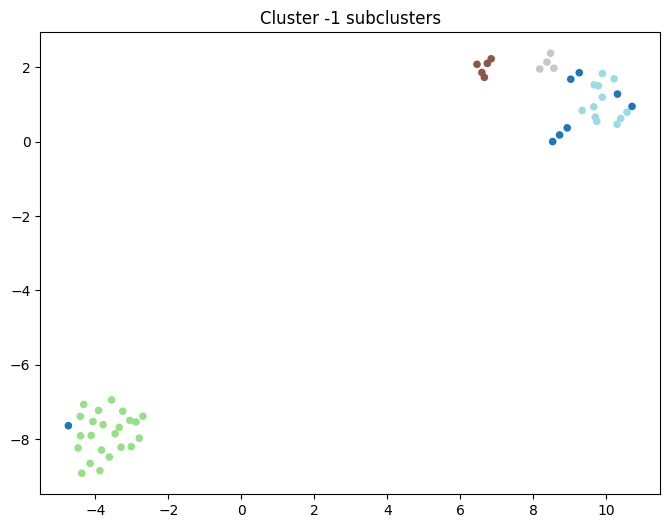


Processing Cluster 1 (336 cases)


Batches: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


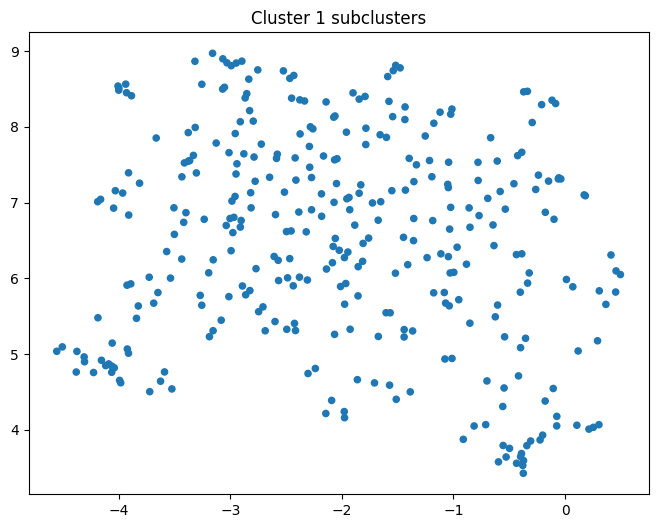


Processing Cluster 5 (86 cases)


Batches: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

  Subcluster 0: 6 cases | Top words: mr, applicant, sentence, jurisdiction, offender, child, said, communications, defendant, sentencing
  Subcluster 1: 3 cases | Top words: para, night, activity, sex, don, old, motive, conversation, friends, police


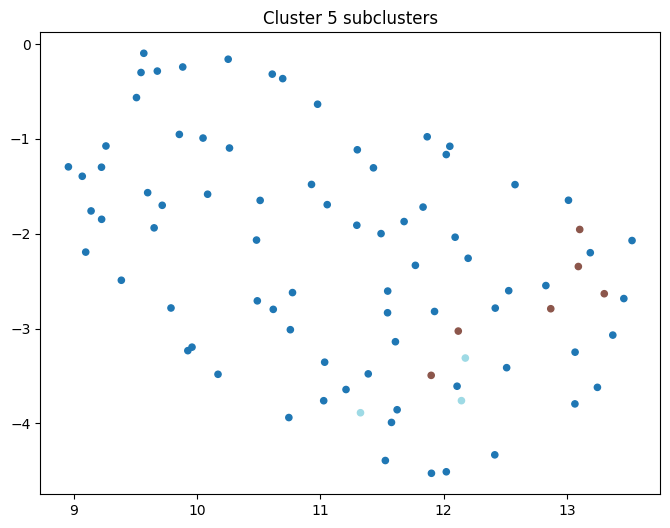


Sub-clustering complete! Selected clusters now have subcluster labels and top keywords.


In [29]:
# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight & fast

# Only sub-cluster these main clusters
clusters_to_process = [-1, 1, 5]

# Dictionary to store subcluster labels and top words
subcluster_results = {}
subcluster_keywords = {}

# Function to get top TF-IDF words for a list of texts
def get_top_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_sums = X.sum(axis=0).A1
    top_indices = tfidf_sums.argsort()[::-1][:top_n]
    return feature_names[top_indices]

# Loop through selected clusters and sub-cluster
for cluster in clusters_to_process:
    cluster_mask = df['Cluster'] == cluster
    cluster_texts = [text for text, mask in zip(texts, cluster_mask) if mask]
    
    if len(cluster_texts) == 0:
        continue
    
    print(f"\nProcessing Cluster {cluster} ({len(cluster_texts)} cases)")
    
    # Generate embeddings
    embeddings = model.encode(cluster_texts, show_progress_bar=True)
    
    # HDBSCAN sub-clustering
    subclusterer = hdbscan.HDBSCAN(
        min_cluster_size=3, 
        metric='euclidean', 
        cluster_selection_method='eom'
    )
    subcluster_labels = subclusterer.fit_predict(embeddings)
    
    # Store subcluster labels
    subcluster_results[cluster] = subcluster_labels
    
    # Store top keywords per subcluster
    subcluster_keywords[cluster] = {}
    unique_subclusters = np.unique(subcluster_labels)
    
    for sc in unique_subclusters:
        if sc == -1:
            continue  # skip noise
        sc_texts = [text for text, lbl in zip(cluster_texts, subcluster_labels) if lbl == sc]
        top_words = get_top_keywords(sc_texts, top_n=10)
        subcluster_keywords[cluster][sc] = top_words
        print(f"  Subcluster {sc}: {len(sc_texts)} cases | Top words: {', '.join(top_words)}")
    
    # Optional: UMAP visualization
    umap_embeddings = umap.UMAP(
        n_neighbors=15, 
        n_components=2, 
        metric='cosine'
    ).fit_transform(embeddings)
    
    plt.figure(figsize=(8,6))
    plt.scatter(
        umap_embeddings[:,0], 
        umap_embeddings[:,1], 
        c=subcluster_labels, 
        cmap='tab20', 
        s=20
    )
    plt.title(f"Cluster {cluster} subclusters")
    plt.show()

# Add subcluster labels to df
for cluster, labels in subcluster_results.items():
    mask = df['Cluster'] == cluster
    df.loc[mask, f'Subcluster_{cluster}'] = labels

print("\nSub-clustering complete! Selected clusters now have subcluster labels and top keywords.")



In [30]:
#print the top keywords per sub-cluster

print("Top keywords per subcluster:\n")

for cluster in subcluster_keywords:
    print(f"Main Cluster {cluster}:")
    for sc, words in subcluster_keywords[cluster].items():
        print(f"  Subcluster {sc} ({len([text for text, lbl in zip(texts, df['Cluster']) if lbl == cluster])} cases): {', '.join(words)}")
    print()


Top keywords per subcluster:

Main Cluster -1:
  Subcluster 0 (52 cases): defendant, sentence, ms, officer, offender, charter, breath, vehicle, para, allen
  Subcluster 1 (52 cases): defendant, complainant, sentence, ms, mr, accused, para, incident, offender, sentencing
  Subcluster 2 (52 cases): ms, complainant, force, website, fear, threatening, children, time, stated, mr
  Subcluster 3 (52 cases): mr, sentence, ms, defendant, offender, messages, delay, records, consent, doubt

Main Cluster 1:

Main Cluster 5:
  Subcluster 0 (86 cases): mr, applicant, sentence, jurisdiction, offender, child, said, communications, defendant, sentencing
  Subcluster 1 (86 cases): para, night, activity, sex, don, old, motive, conversation, friends, police



**Sub-Cluster Analysis**

- Cluster -1:
    * Subcluster 0: Likely procedural or traffic/Charter-related cases, including vehicle offenses, driving under influence, or other legal procedural matters.
     * Subcluster 1: Probably general criminal cases, possibly minor assaults, property crimes, or mixed offenses; broadly procedural with no strong thematic signal.
     * Subcluster 2: Likely sexual offenses or threats, some involving minors, possibly online/technology-facilitated offenses.
     * Subcluster 3: ikely assault or sexual consent-related cases, procedural context emphasized (delay, records, consent), overlaps with sexual/offense context.

- Cluster 5:
    * Subcluster 0: Likely child-related general criminal cases, maybe minor abuse or family-related criminal offenses. Procedural and sentencing context is strong.
     * Subcluster 1:Likely sexual offenses in social contexts, possibly assaults at parties or social gatherings, involving victims and witnesses.


In [35]:
df.head()

,Judge,Heard_Date,Released_Date,Case_Title,URL,Cluster,Subcluster_-1,Subcluster_1,Subcluster_5
0,C.A. Brannagan,27 November 2025,2025-12-31,R. v. M.T.,https://www.canlii.org/en/on/oncj/doc/2025/202...,4,NaN,NaN,NaN
1,Fergus ODonnell,Unknown,2025-12-30,R. v. J.G.,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN
2,S. Robichaud,"October 27 to October 31, November 12, 17-25, ...",2025-12-29,R. v. Laguerre,https://www.canlii.org/en/on/oncj/doc/2025/202...,4,NaN,NaN,NaN
3,S. Robichaud,"December 29, 2025",2025-12-29,R. v. Khosa,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN
4,S. G. Pratt,"4 November, 17 December, 2025",2025-12-24,R. v. Lachance,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN
